In [46]:
# Libraries and utilities

# RENINDER: FARE FIT.TRANSFORM SOLO SU TRAINING E DOPO SUL TEST SOLO .TRANSFORM
# REMINDER: NORMALIZZARE PRIMA DI FARE TUTTO IL PREPROCESSING 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler, OneHotEncoder
from sklearn import preprocessing

from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold, RandomizedSearchCV,GridSearchCV, RepeatedKFold, train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

from scikitplot.metrics import plot_roc

from collections import Counter
from imblearn.datasets import make_imbalance

from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
df_train=pd.read_csv("../Dataset_prepared/Prepared_train.csv")
df_test=pd.read_csv("../Dataset_prepared/Prepared_test.csv")

df_train.drop('actor',axis=1,inplace=True)
df_train.drop('filename',axis=1,inplace=True)

df_test.drop('actor',axis=1,inplace=True)
df_test.drop('filename',axis=1,inplace=True)

In [3]:

#creating instance of one-hot-encoder
encoder = OneHotEncoder()
#perform one-hot encoding on 'emotion' column 
encoder_df = pd.DataFrame(encoder.fit_transform(df_train[['emotion']]).toarray())
encoder_df_test = pd.DataFrame(encoder.fit_transform(df_test[['emotion']]).toarray())
#merge one-hot encoded columns back with original DataFrame
df_train = df_train.join(encoder_df)
df_test = df_test.join(encoder_df_test)
#drop 'emotion' column
df_train.drop('emotion', axis=1, inplace=True)
df_test.drop('emotion', axis=1, inplace=True)
#rename 0=Angry column
df_train.rename(columns = {0:'IsAngry?'}, inplace = True)
df_test.rename(columns = {0:'IsAngry?'}, inplace = True)
#drop other emotion columns
df_train.drop([1,2,3,4,5,6,7],axis=1,inplace=True)
df_test.drop([1,2,3,4,5,6,7],axis=1,inplace=True)
#transform IsAngry? from float to integer
df_train['IsAngry?'] = df_train['IsAngry?'].astype(int)
df_test["IsAngry?"] = df_test['IsAngry?'].astype(int)


In [4]:
df_train.head()

,vocal_channel,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,kur,...,stft_sum_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4,IsAngry?
0,speech,normal,Kids are talking by the door,1st,M,9.150000e-07,-0.000031,0.0,0.0,15.028520,...,740.409892,0.000000,0.566462,0.709962,0.799141,0.896606,1.0,6.742190,-1.706215,0
1,speech,normal,Kids are talking by the door,2nd,M,7.137790e-07,-0.000031,0.0,0.0,16.488415,...,705.975006,0.368623,0.472736,0.623183,0.744908,0.874713,1.0,-0.700420,-0.201495,0
2,speech,normal,Dogs are sitting by the door,1st,M,9.554485e-07,0.000000,0.0,0.0,17.035218,...,694.365924,0.000000,0.417919,0.643636,0.774253,0.899156,1.0,1.688986,-1.024773,0
3,speech,normal,Dogs are sitting by the door,2nd,M,9.176213e-07,-0.000031,0.0,0.0,21.824521,...,663.205667,0.306280,0.399641,0.606910,0.755213,0.886474,1.0,-0.594111,-0.412871,0
4,speech,normal,Kids are talking by the door,1st,M,8.108948e-07,-0.000031,0.0,0.0,13.236022,...,741.412796,0.248765,0.428202,0.634815,0.759914,0.878014,1.0,0.126535,-0.620782,0


In [5]:
df_test.head()

,vocal_channel,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,kur,...,stft_sum_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4,IsAngry?
0,speech,normal,Kids are talking by the door,1st,M,2.940224e-06,-0.000092,0.0,0.000153,11.392131,...,727.157574,0.306697,0.466157,0.645931,0.789123,0.908316,1.0,-0.260279,-0.566556,0
1,speech,normal,Kids are talking by the door,2nd,M,7.733752e-07,-0.000122,0.0,0.000153,13.621589,...,637.658102,0.170786,0.279347,0.557524,0.733053,0.866973,1.0,-0.428900,-0.587210,0
2,speech,normal,Dogs are sitting by the door,1st,M,-3.741909e-06,-0.000061,0.0,0.000092,7.678162,...,672.592436,0.023285,0.305395,0.577750,0.741576,0.889984,1.0,0.626916,-0.883317,0
3,speech,normal,Dogs are sitting by the door,2nd,M,-5.069646e-07,-0.000092,0.0,0.000122,14.511231,...,704.158385,0.368081,0.434591,0.620144,0.776419,0.904668,1.0,-0.825144,-0.383701,0
4,speech,normal,Kids are talking by the door,1st,M,8.640319e-07,-0.000061,0.0,0.000122,8.944732,...,780.167518,0.298851,0.393112,0.623309,0.772964,0.907035,1.0,-0.536669,-0.547354,0


In [6]:
# Percentage of Angry records in train and test datasets
train_values=df_train.values
train_target=np.array(df_train["IsAngry?"])
test_values=df_test.values
test_target=np.array(df_test["IsAngry?"])

In [7]:
print(f"Valori ed etichette nel train:{len(train_values), len(train_target)}")
print(f"Valori ed etichette nel test:{len(test_values), len(test_target)}")

Valori ed etichette nel train:(1828, 1828)
Valori ed etichette nel test:(624, 624)


In [8]:
np.unique(train_target, return_counts=True), np.unique(test_target, return_counts=True)


((array([0, 1]), array([1548,  280], dtype=int64)),
 (array([0, 1]), array([528,  96], dtype=int64)))

In [9]:
print(f"Train !Angry: {1548/1828}, Train Angry: {280/1828}")
print(f"Test  !Angry: {528/624}, Train Angry: {96/624}")

Train !Angry: 0.8468271334792122, Train Angry: 0.15317286652078774
Test  !Angry: 0.8461538461538461, Train Angry: 0.15384615384615385


In [10]:
# Label encoding categorical columns for train and test
le=preprocessing.LabelEncoder()
c = df_train.select_dtypes(include=['object']).columns.tolist()
for i in c:
    df_train[i]=le.fit_transform(df_train[i])

for i in c:
    df_test[i]=le.fit_transform(df_test[i])


#Normalization numerical pure feature for training and test
scaler = StandardScaler()
numeric_features = [n for n in df_train.columns if n!="IsAngry?" and n!= "vocal_channel" and n!= "emotional_intensity" and n!= "statement" and n!= "repetition" and n!= "sex"]
scaled_features = scaler.fit_transform(df_train[numeric_features])
df_train[numeric_features] = scaled_features


scaled_features_test = scaler.transform(df_test[numeric_features])
df_test[numeric_features] = scaled_features_test

In [11]:
df_train.head()

,vocal_channel,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,kur,...,stft_sum_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4,IsAngry?
0,1,0,1,0,1,0.018034,0.603864,-0.063106,-0.7693,0.553248,...,0.161158,-0.925138,2.167997,1.515260,1.079945,0.690192,0.036057,9.400360,-3.035005,0
1,1,0,1,1,1,0.013950,0.603864,-0.063106,-0.7693,0.770118,...,-0.173413,1.908839,1.610931,0.996435,0.639413,0.409754,0.036057,-0.186504,0.434538,0
2,1,0,0,0,1,0.018855,0.622665,-0.063106,-0.7693,0.851346,...,-0.286208,-0.925138,1.285119,1.118715,0.877776,0.722854,0.036057,2.891302,-1.463754,0
3,1,0,0,1,1,0.018087,0.603864,-0.063106,-0.7693,1.562804,...,-0.588962,1.429546,1.176485,0.899140,0.723117,0.560400,0.036057,-0.049566,-0.052845,0
4,1,0,1,0,1,0.015921,0.603864,-0.063106,-0.7693,0.286970,...,0.170902,0.987370,1.346235,1.065980,0.761301,0.452031,0.036057,0.878701,-0.532241,0


In [12]:
df_test.head()

,vocal_channel,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,kur,...,stft_sum_w4,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_kur_w4,stft_skew_w4,IsAngry?
0,1,0,1,0,1,0.059131,0.566262,-0.063106,-0.66600,0.013057,...,0.032398,1.432748,1.571823,1.132435,0.998570,0.840181,0.036057,0.380443,-0.407209,0
1,1,0,1,1,1,0.015160,0.547461,-0.063106,-0.66600,0.344246,...,-0.837184,0.387863,0.461505,0.603874,0.543109,0.310605,0.036057,0.163243,-0.454832,0
2,1,0,0,0,1,-0.076467,0.585063,-0.063106,-0.70732,-0.538658,...,-0.497760,-0.746120,0.616325,0.724799,0.612342,0.605368,0.036057,1.523245,-1.137587,0
3,1,0,0,1,1,-0.010822,0.566262,-0.063106,-0.68666,0.476404,...,-0.191064,1.904671,1.384208,0.978261,0.895372,0.793457,0.036057,-0.347161,0.014413,0
4,1,0,1,0,1,0.016999,0.585063,-0.063106,-0.68666,-0.350507,...,0.547445,1.372430,1.137679,0.997185,0.867312,0.823776,0.036057,0.024425,-0.362935,0


In [13]:
col=[x for x in df_train.columns if x!="IsAngry?"]
X_train=df_train[col].values
y_train = np.array(df_train["IsAngry?"])

X_test=df_test[col].values
y_test = np.array(df_test["IsAngry?"])

Fit two models based on DT and KNN

DT

In [14]:
param_grid = {'max_depth': [None, 2, 5, 10, 15, 20],
              'min_samples_split': [2, 5, 10, 15, 20],
              'min_samples_leaf': [1, 5, 10, 15, 20]
}

grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=StratifiedKFold(), # with no parameters it is with 5 split and 10 repetitions
    refit=True,
    scoring="f1_macro"
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_

In [15]:
print(grid.best_params_)

{'max_depth': None, 'min_samples_leaf': 15, 'min_samples_split': 2}


In [16]:
learner = DecisionTreeClassifier(max_depth=None,min_samples_split=2,min_samples_leaf=15)
classifier = learner.fit(X_train, y_train)
predictions = classifier.predict(X_test)

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       528
           1       0.61      0.64      0.62        96

    accuracy                           0.88       624
   macro avg       0.77      0.78      0.78       624
weighted avg       0.88      0.88      0.88       624



KNN

In [69]:
param_grid = {
    "n_neighbors": np.arange(2,51),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cityblock","minkowski"], # cityblock is the manhattan distance
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=StratifiedKFold(), # with no parameters it is with 5 split and 10 repetitions
    refit=True,
    scoring="f1_macro"
)

grid.fit(X_train, y_train)
clf = grid.best_estimator_

In [70]:
print(grid.best_params_)

{'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}


In [73]:
learner = KNeighborsClassifier(n_neighbors= 5, metric= 'euclidean', weights= 'uniform')
classifier = learner.fit(X_train, y_train)
predictions = classifier.predict(X_test)

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       528
           1       0.69      0.51      0.59        96

    accuracy                           0.89       624
   macro avg       0.80      0.73      0.76       624
weighted avg       0.88      0.89      0.88       624



Let's see the distribution of IsAngry? feature on train set

In [17]:
df_train["IsAngry?"].value_counts()

0    1548
1     280
Name: IsAngry?, dtype: int64

<AxesSubplot:xlabel='IsAngry?', ylabel='count'>

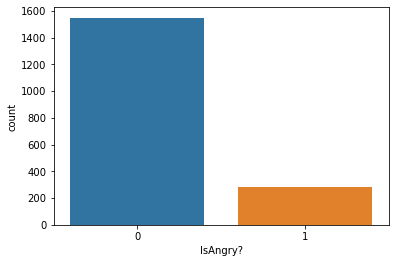

In [18]:
sns.countplot(data=df_train,x="IsAngry?")

Let's try to unbalance more the IsAngry? feature to 95% -> class 0 and 5% -> class 1 for train and test set

In [30]:
df_copy_train=df_train.copy()

indexNames=df_train[df_train["IsAngry?"]==1].sample(frac=0.70).index
df_copy_train.drop(indexNames,axis=0,inplace=True)

In [31]:
df_copy_train["IsAngry?"].value_counts(normalize=True)

0    0.948529
1    0.051471
Name: IsAngry?, dtype: float64

In [32]:
df_copy_train["IsAngry?"].value_counts()

0    1548
1      84
Name: IsAngry?, dtype: int64

<AxesSubplot:xlabel='IsAngry?', ylabel='count'>

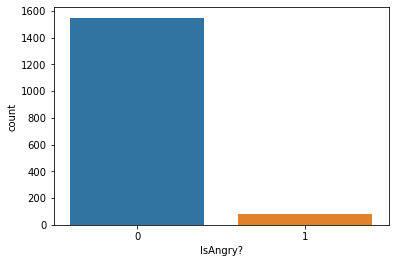

In [33]:
sns.countplot(data=df_copy_train,x="IsAngry?")

In [35]:
#Let's do the same unbalancing also for the test set
df_copy_test=df_test.copy()
indexNames=df_test[df_test["IsAngry?"]==1].sample(frac=0.70).index
df_copy_test.drop(indexNames,axis=0,inplace=True)
df_copy_test["IsAngry?"].value_counts(normalize=True)

0    0.947935
1    0.052065
Name: IsAngry?, dtype: float64

In [36]:
df_copy_test["IsAngry?"].value_counts()

0    528
1     29
Name: IsAngry?, dtype: int64

In [37]:
#Let's define the new set of train and test

col=[x for x in df_copy_train.columns if x!="IsAngry?"]
X_train_unb=df_copy_train[col].values
y_train_unb = np.array(df_copy_train["IsAngry?"])

X_test_unb=df_copy_test[col].values
y_test_unb = np.array(df_copy_test["IsAngry?"])

Let's build two models based on DT and KNN in this very unbalanced case

DT

In [38]:
param_grid = {'max_depth': [None, 2, 5, 10, 15, 20],
              'min_samples_split': [2, 5, 10, 15, 20],
              'min_samples_leaf': [1, 5, 10, 15, 20]
}

grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=StratifiedKFold(), # with no parameters it is with 5 split and 10 repetitions
    refit=True,
    scoring="f1_macro"
)
grid.fit(X_train_unb, y_train_unb)
clf = grid.best_estimator_
print(grid.best_params_)

{'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 15}


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       528
           1       0.62      0.55      0.58        29

    accuracy                           0.96       557
   macro avg       0.80      0.77      0.78       557
weighted avg       0.96      0.96      0.96       557



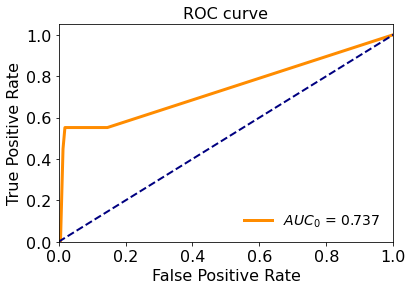

In [60]:
learner = DecisionTreeClassifier(max_depth=10,min_samples_split=15,min_samples_leaf=10)
classifier = learner.fit(X_train_unb, y_train_unb)
predictions = classifier.predict(X_test_unb)

print(classification_report(y_test_unb,predictions))

y_score = classifier.predict_proba(X_test_unb)
fpr0, tpr0, thr = roc_curve(y_test_unb, y_score[:,1])
roc_auc0 = auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

KNN

In [40]:
param_grid = {
    "n_neighbors": np.arange(2,51),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "cityblock","minkowski"], # cityblock is the manhattan distance
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=StratifiedKFold(), # with no parameters it is with 5 split and 10 repetitions
    refit=True,
    scoring="f1_macro"
)

grid.fit(X_train_unb, y_train_unb)
clf = grid.best_estimator_
print(grid.best_params_)

{'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}


In [41]:
learner = KNeighborsClassifier(n_neighbors= 2, metric= 'euclidean', weights= 'distance')
classifier = learner.fit(X_train_unb, y_train_unb)
predictions = classifier.predict(X_test_unb)

print(classification_report(y_test_unb,predictions))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       528
           1       0.29      0.24      0.26        29

    accuracy                           0.93       557
   macro avg       0.63      0.60      0.61       557
weighted avg       0.92      0.93      0.93       557

